# 0.0. Imports

In [63]:
import numpy as np
import pandas as pd
from boruta import BorutaPy as by
import scikitplot as skplt
import pickle
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import preprocessing as pp
from sklearn import linear_model as lm
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh

from sklearn.metrics import top_k_accuracy_score

## 0.1. Helper Function

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

## 0.2. Load Dataset

In [4]:
df_raw = pd.read_csv('../data/raw/train.csv')
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0. Data Description

In [5]:
df1 = df_raw.copy()

In [6]:
df1 = df1.rename(columns = str.lower)
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 1.1. Data Dimension

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 381109
Number of columns: 12


## 1.2. Data Types

In [8]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Check NA

In [9]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4. Data Descriptive

In [10]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [11]:
# central tendency - mean and median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T 
d2 = pd.DataFrame( num_attributes.apply(min)).T 
d3 = pd.DataFrame( num_attributes.apply(max)).T 
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min())).T 
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew())).T 
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis())).T 

# concatenate
con = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
con.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
con

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0. Feature Engineering

In [12]:
df2 = df1.copy()

In [13]:
 # vehicle age
df2['vehicle_age'] =  df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 
                                            'between_1_2_year' if x == '1-2 Year' else 
                                            'below_1_year')

# vehicle damage
df2['vehicle_damage'] =  df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0. Data Filtering

In [14]:
df3 = df2.copy()

# 4.0. Exploratory Data Analysis

In [15]:
df4 = df3.copy()

## 4.1. Univariate Analysis

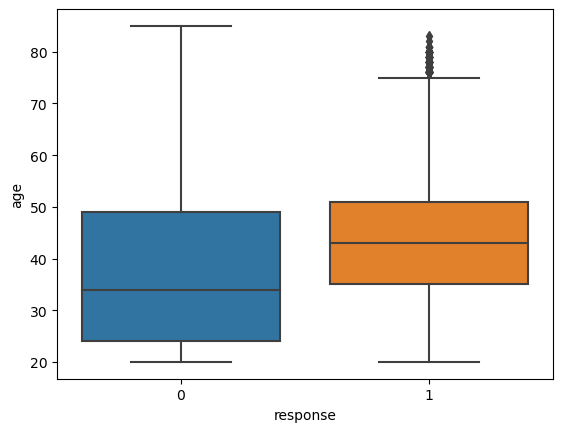

In [16]:
# age

sns.boxplot(x = 'response', y = 'age', data = df4);

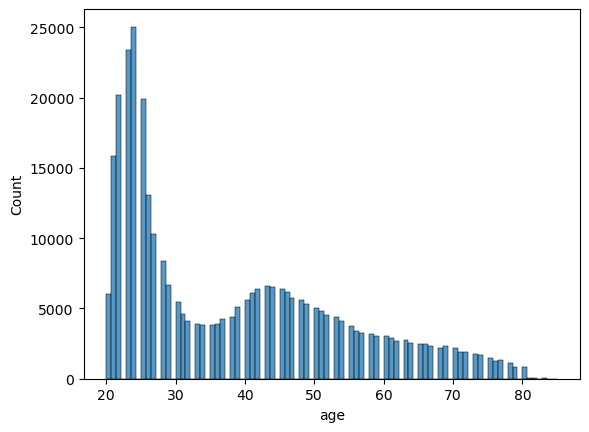

In [17]:
aux1 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux1);

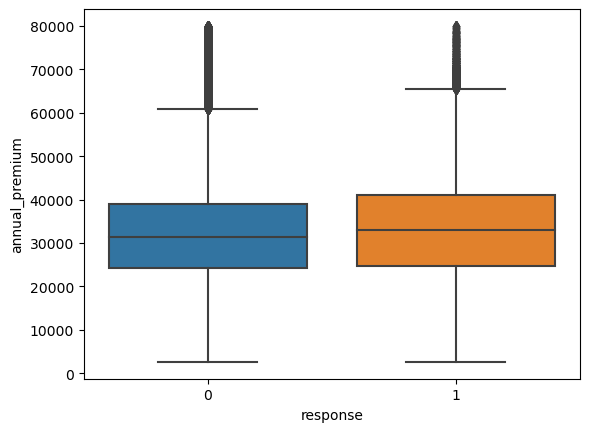

In [18]:
# annual premium

aux2 = df4[df4['annual_premium'] < 80000]
sns.boxplot(x = 'response', y = 'annual_premium', data = aux2);

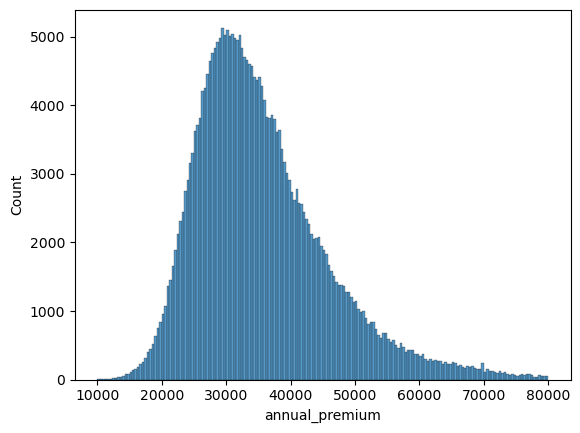

In [19]:
aux3 = df4[(df4['annual_premium'] > 10000) &(df4['annual_premium'] < 80000 )]
aux4 = aux3.loc[aux3['response'] == 0, 'annual_premium']
sns.histplot(aux4);

<AxesSubplot: xlabel='annual_premium', ylabel='Count'>

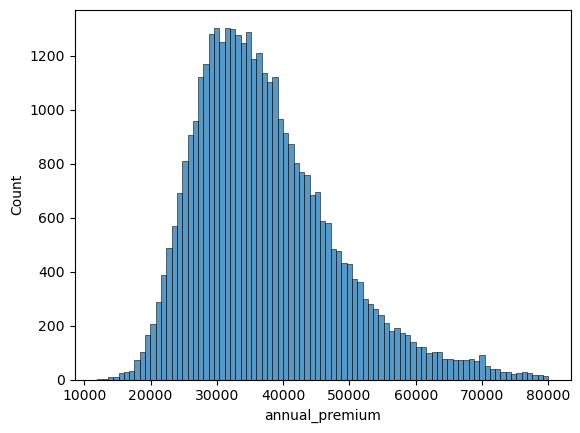

In [20]:
aux5 = aux3.loc[aux3['response'] == 1, 'annual_premium']
sns.histplot(aux5)

<AxesSubplot: xlabel='response', ylabel='driving_license'>

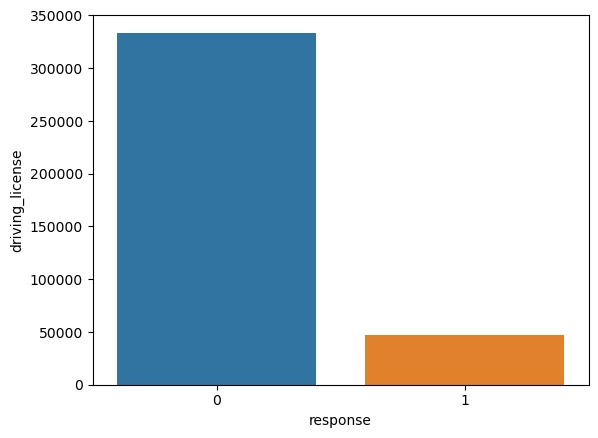

In [21]:
# driving_license

aux6 = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux6['driving_license_perc'] = aux6['driving_license'] / aux6['driving_license'].sum()
sns.barplot(x='response', y='driving_license', data=aux6)

In [22]:
# region_code -> this didn't worked, why?

# aux7 = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index
# aux7
# #sns.scatterplot(x = 'region_code', y = 'id', hue = 'response', data = aux7);

In [23]:
# gender -> não fizemos

In [24]:
# previously_insured
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x / x.sum(), axis = 1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [25]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts(normalize = True).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


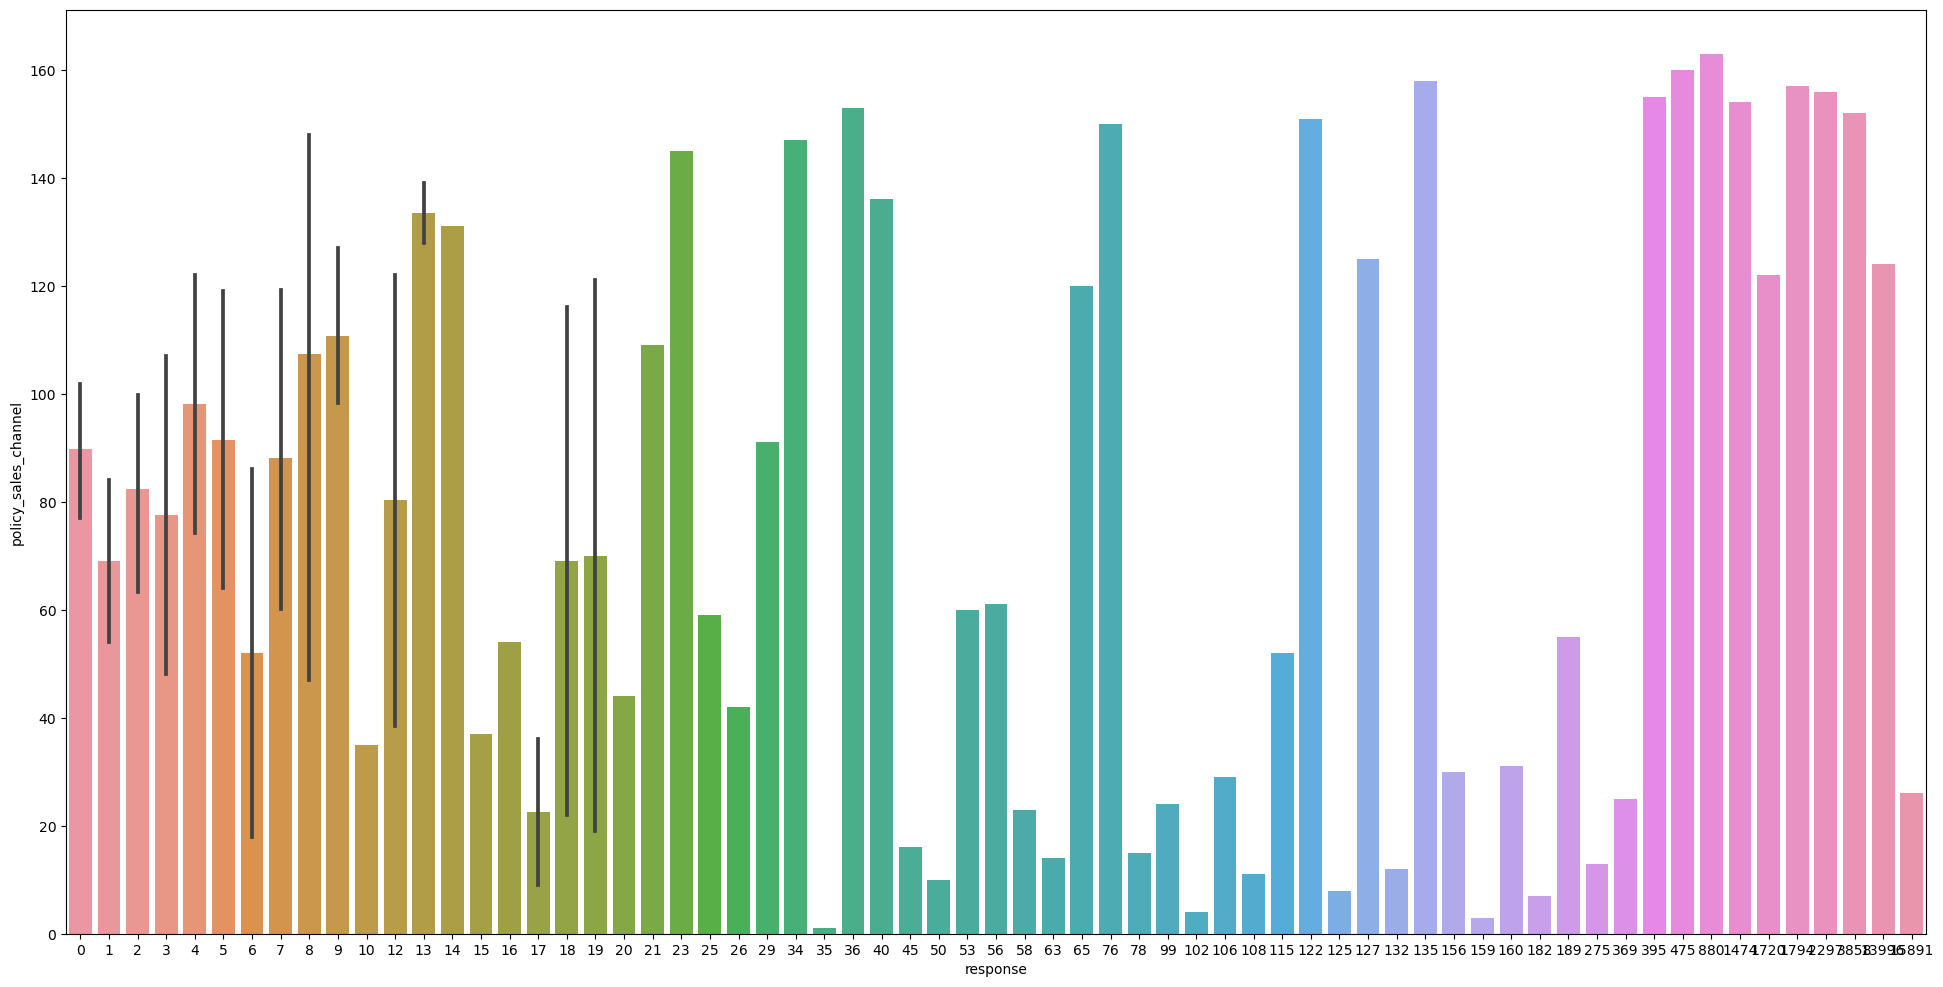

In [26]:
# policy_sales_channel
plt.figure(figsize = (24, 12))
aux8 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x = 'response', y = 'policy_sales_channel', data = aux8);

In [27]:
# vintage

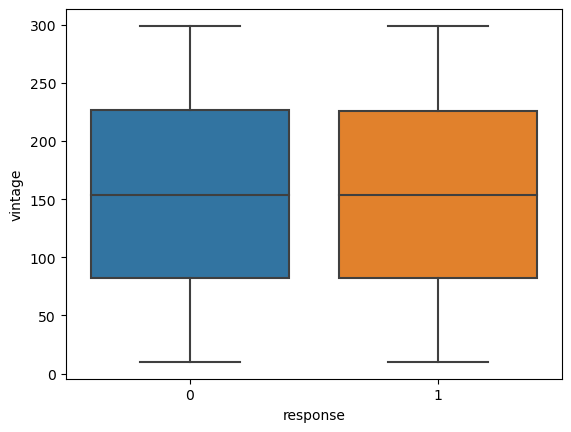

In [28]:
# annual_premium
sns.boxplot(x = 'response', y = 'vintage', data = df4);

<AxesSubplot: xlabel='vintage', ylabel='Count'>

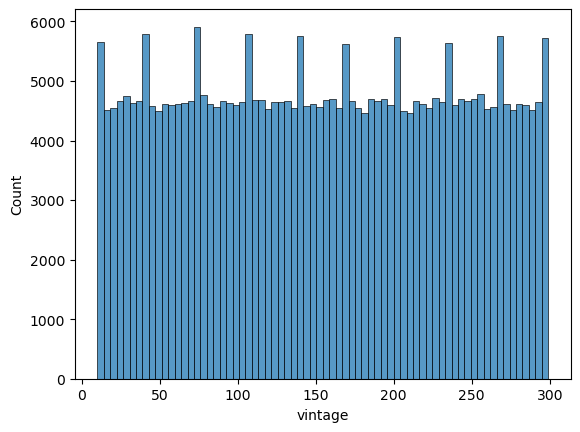

In [29]:
aux9 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux9)

<AxesSubplot: xlabel='vintage', ylabel='Count'>

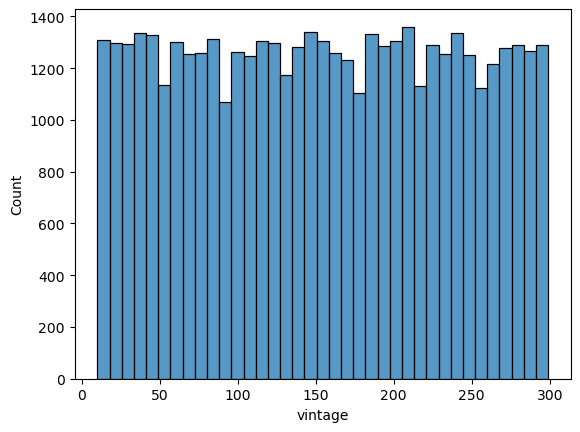

In [30]:
aux10 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux10)

# 5.0. Data Preparation

In [31]:
df5 = df4.copy()

In [32]:
X = df4.drop('response', axis = 1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size = 0.20)
df5 = pd.concat([x_train, y_train], axis = 1)

## 5.1. Standardization

In [33]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## 5.2. Rescaling

In [34]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

## 5.3. Encoding

In [35]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender)

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code)

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

C:\Users\pgdem\AppData\Local\Temp\ipykernel_18252\2212422765.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender)


In [36]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map(target_encode_gender)

# age
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

# fillna
x_validation = x_validation.fillna(0)

C:\Users\pgdem\AppData\Local\Temp\ipykernel_18252\2981410032.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map(target_encode_gender)


# 6.0. Feature Selection

## 6.1. Selection With Boruta Algorithm

### 6.1.2. ExtraTreesClassifier

In [37]:
# ExtraTreesClassifier

x_train_n = df5.drop(['id', 'response'], axis=1).values
y_train_n = y_train.values.ravel()

# Define model
et = en.ExtraTreesClassifier(n_jobs=-1)

# Define boruta
boruta_et = by(et, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
I

In [38]:
cols_selected_et = boruta_et.support_.tolist()

# best features according to ExtraTreesClassifier
x_train_et = df5.drop(['id', 'response'], axis = 1)
cols_selected_boruta_et = x_train_et.iloc[:, cols_selected_et].columns.to_list()

# not selected boruta
cols_not_selected_boruta_et = list( np.setdiff1d(x_train_et.columns, cols_selected_boruta_et))

### 6.1.3. RandomForestClassifier

In [39]:
# RandomForestClassifier

x_train_n2 = df5.drop(['id', 'response'], axis=1).values
y_train_n2 = y_train.values.ravel()

# Define model
rf = en.RandomForestClassifier(n_jobs = -1, max_depth = 5)

# Define boruta
boruta_rf = by(rf, n_estimators= 'auto' , verbose=2, random_state=42).fit(x_train_n2, y_train_n2)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	1


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	1


In [40]:
cols_selected_rf = boruta_rf.support_.tolist()

# best features according to ExtraTreesClassifier
x_train_rf = df5.drop(['id', 'response'], axis = 1)
cols_selected_boruta_rf = x_train_rf.iloc[:, cols_selected_rf].columns.to_list()

# not selected boruta
cols_not_selected_boruta_rf = list( np.setdiff1d(x_train_rf.columns, cols_selected_boruta_rf))

## 6.2. Feature Importance

## 6.2.1. With ExtraTreesClassifier

In [41]:
# model definition
extratrees = en.ExtraTreesClassifier(n_estimators=250, random_state = 0, n_jobs = -1)

# data preparation
x_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
extratrees.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.273315
0                annual_premium    0.244927
0                           age    0.166054
0                   region_code    0.103966
0                vehicle_damage    0.067974
0          policy_sales_channel    0.059397
0            previously_insured    0.056649
0      vehicle_age_below_1_year    0.013879
0  vehicle_age_between_1_2_year    0.006199
0                        gender    0.004892
0      vehicle_age_over_2_years    0.002255
0               driving_license    0.000494


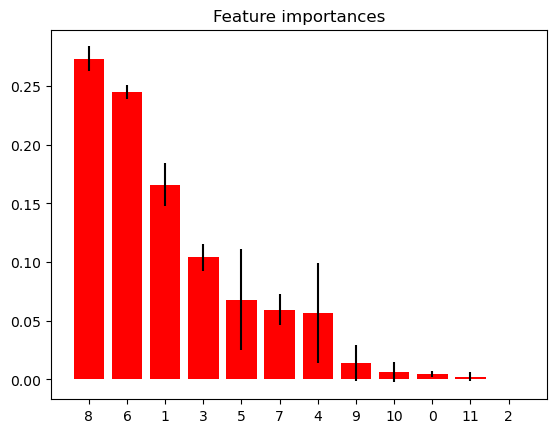

In [42]:
importances = extratrees.feature_importances_
std = np.std([tree.feature_importances_ for tree in extratrees.estimators_], axis=0)
indexes = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, extratrees.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the extra trees
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indexes], color="r", yerr=std[indexes], align="center")
plt.xticks(range(x_train_n.shape[1]), indexes)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

## 6.2.2. With RandomForestClassifier

In [43]:
# model definition
randomtrees = en.RandomForestClassifier(n_jobs = -1, max_depth = 5)

# data preparation
x_train_n2 = df5.drop(['id', 'response'], axis=1)
y_train_n2 = y_train.values
randomtrees.fit(x_train_n2, y_train_n2)

RandomForestClassifier(max_depth=5, n_jobs=-1)

Feature ranking:
                        feature  importance
0                vehicle_damage    0.435713
0            previously_insured    0.269913
0                           age    0.120519
0          policy_sales_channel    0.063693
0      vehicle_age_below_1_year    0.052487
0  vehicle_age_between_1_2_year    0.021831
0                   region_code    0.019781
0      vehicle_age_over_2_years    0.011012
0                annual_premium    0.003453
0                        gender    0.000955
0               driving_license    0.000339
0                       vintage    0.000303


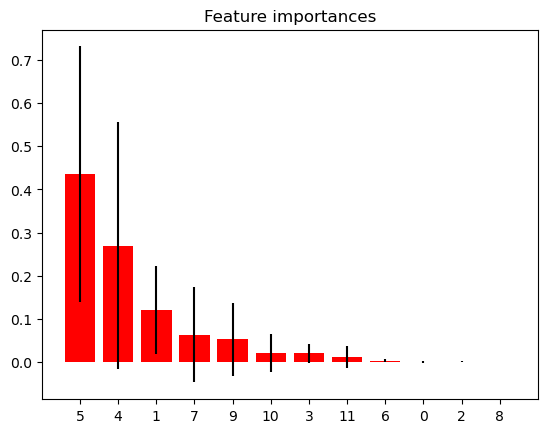

In [44]:
importances = randomtrees.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomtrees.estimators_], axis=0)
indexes = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n2, randomtrees.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the extra trees
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n2.shape[1]), importances[indexes], color="r", yerr=std[indexes], align="center")
plt.xticks(range(x_train_n2.shape[1]), indexes)
plt.xlim([-1, x_train_n2.shape[1]])
plt.show()

# 7.0. Machine Learning Modelling

In [45]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                'policy_sales_channel']

In [46]:
x_train = df5[cols_selected]

x_val = x_validation[cols_selected]
y_val = y_validation

## 7.1. KNN Classifier

In [47]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors = 7)

# model training
knn_model.fit(x_train, y_train)

# model prediction
yhat_knn = knn_model.predict_proba(x_val)

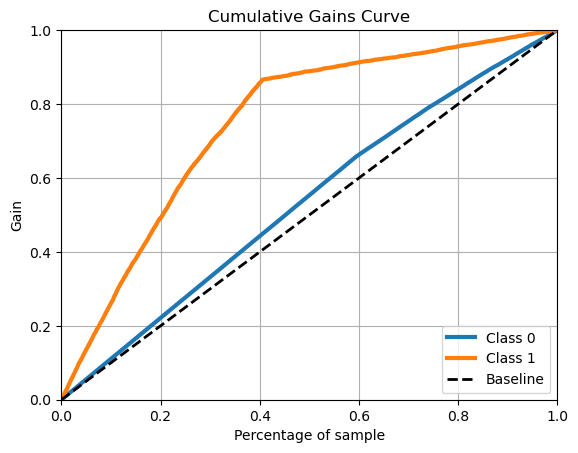

In [48]:
 # Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

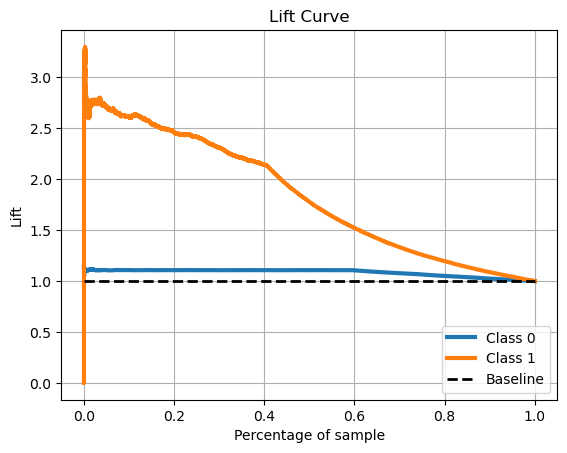

In [49]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_knn );

## 7.2. Logistic Regression

In [50]:
# model definition
lr_model = lm.LogisticRegression(random_state = 42) 

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

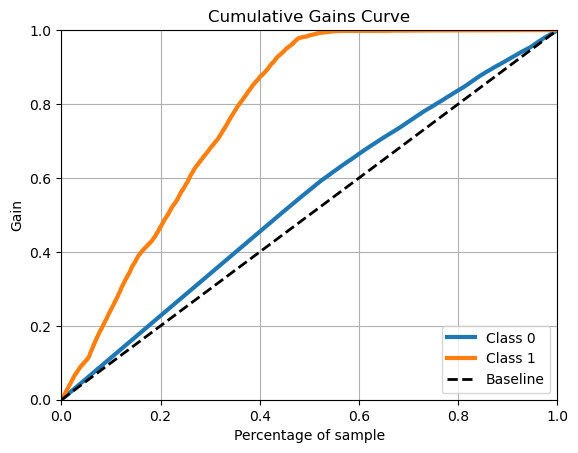

In [51]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

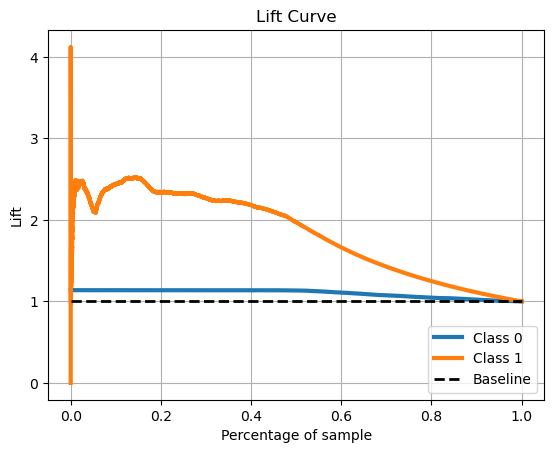

In [52]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_lr );

## 7.3. Extra Trees Classifier

In [54]:
# model definition
et = en.ExtraTreesClassifier(n_estimators = 1000, n_jobs=-1, random_state = 42) 

# model training
et.fit(x_train, y_train)

# model prediction
yhat_et = et.predict_proba(x_val)

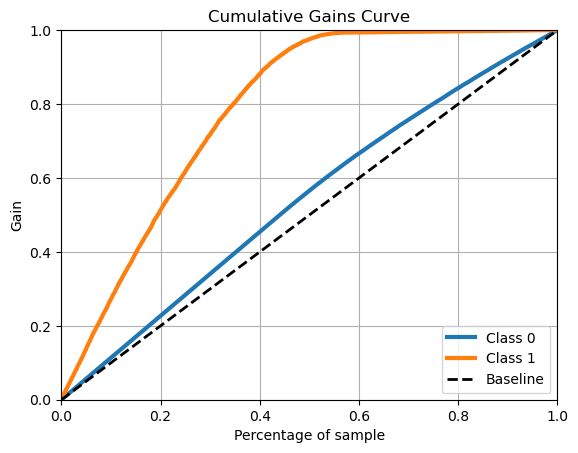

In [55]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_et);

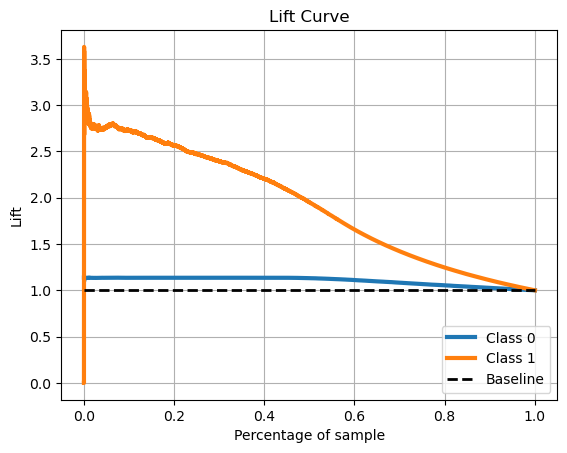

In [56]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve(y_val, yhat_et);

## 7.4. Random Forest

In [57]:
# model definition
rf = en.RandomForestClassifier(n_estimators = 1000, n_jobs = -1, random_state = 42) 

# model training
rf.fit(x_train, y_train)

# model prediction
yhat_rf = et.predict_proba(x_val)

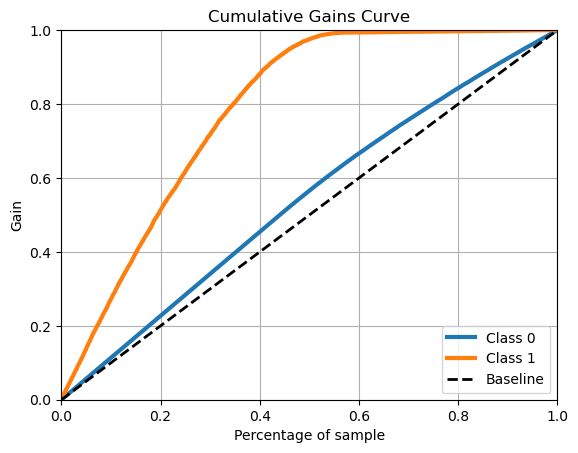

In [58]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf);

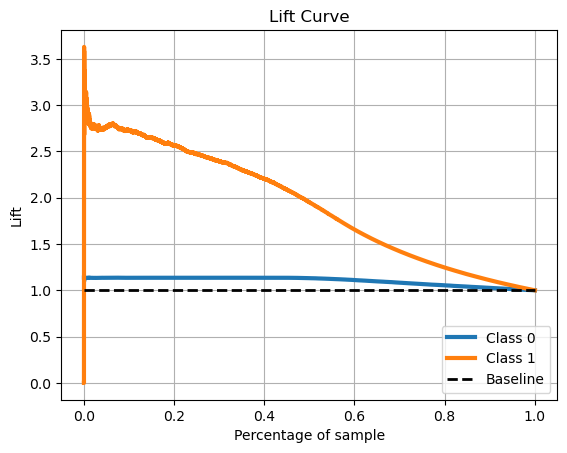

In [59]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve(y_val, yhat_rf);

# 8.0. Performance Metrics

In [77]:
def precision_at_k(data, k = 10):
    data = data.reset_index(drop = True)
    data['ranking'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return (data.loc[ k, 'precision_at_k'], data)

def recall_at_k(data, k = 15):
    data = data.reset_index(drop = True)
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return (data.loc[k, 'recall_at_k'], data)

In [78]:
# copy dataframe
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_et[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values('score', ascending = False)

# compute precision at k 
precision_at_20, data = precision_at_k(df8, k = 20)

# compute recall at k
recall_at_15, data = recall_at_k(df8, k = 15)

In [79]:
y_true = np.array([0, 1, 2, 2])
y_score = np.array([[0.5, 0.2, 0.2],  # 0 is in top 2
                    [0.3, 0.4, 0.2],  # 1 is in top 2
                    [0.2, 0.4, 0.3],  # 2 is in top 2
                    [0.7, 0.2, 0.1]]) # 2 isn't in top 2

top_k_accuracy_score(y_true, y_score, k = 2)

0.75

In [80]:
y_true = np.array([1, 0, 1, 1, 0, 1, 0, 0])
y_score = np.array([])

## 8.1. Cummulative Curve

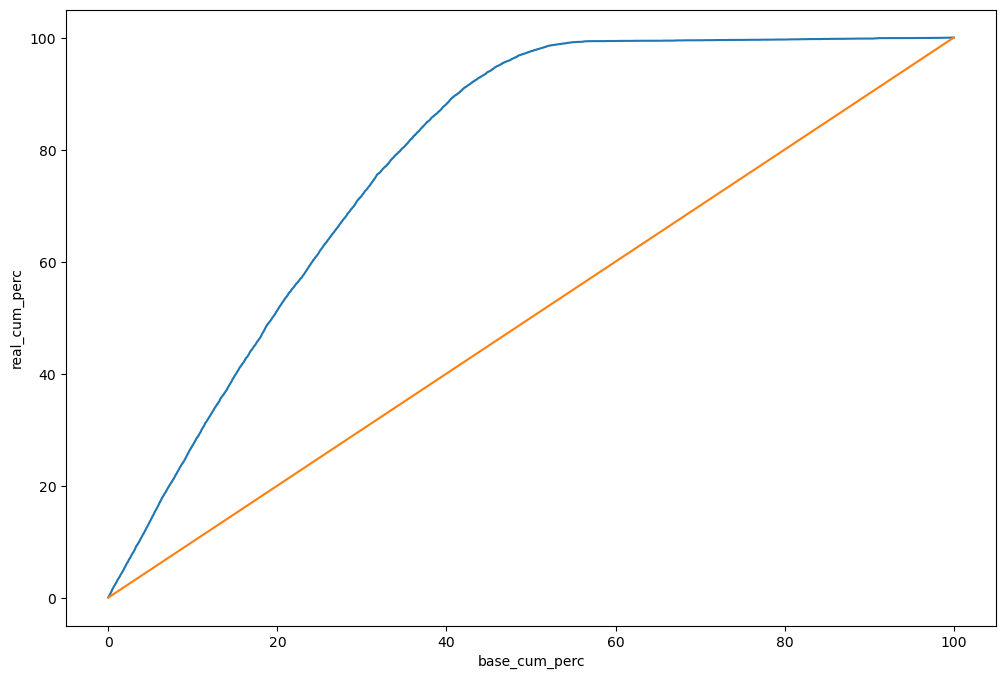

In [81]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values('prediction', ascending=False )

# Percentage of intereset (Propensity Score)
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100 * results['real_cum'] / results['real'].sum()

# Percentage of Base (Clients)
results['base'] = range(1, len( results ) + 1)
results['base_cum_perc'] = 100*results['base'] / len(results)

# Basline model
results['baseline'] = results['base_cum_perc']

plt.figure(figsize = (12,8))
sns.lineplot( x = 'base_cum_perc', y = 'real_cum_perc', data = results )
sns.lineplot( x = 'base_cum_perc', y = 'baseline', data = results );

## 8.2. Lift Curve

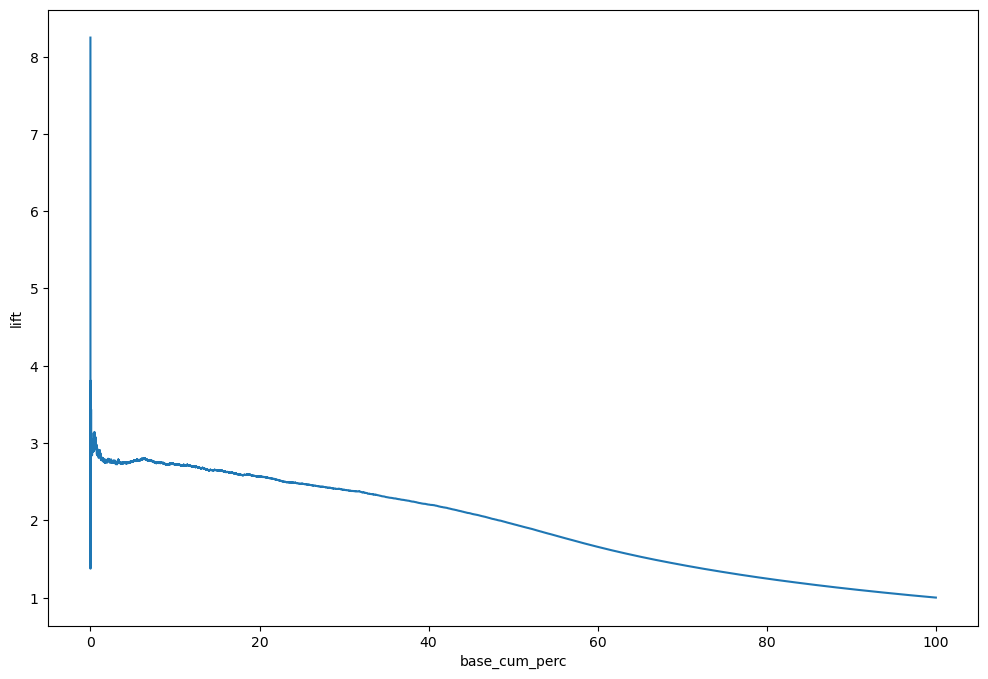

In [84]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values('prediction', ascending = False)

# Percentage of intereset (Propensity Score)
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100 * results['real_cum'] / results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range(1, len( results ) + 1 )
results['base_cum_perc'] = 100 * results['base'] / len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

plt.figure(figsize=(12,8))
sns.lineplot(x = 'base_cum_perc', y = 'lift', data = results );

## 8.3. ROI Curve

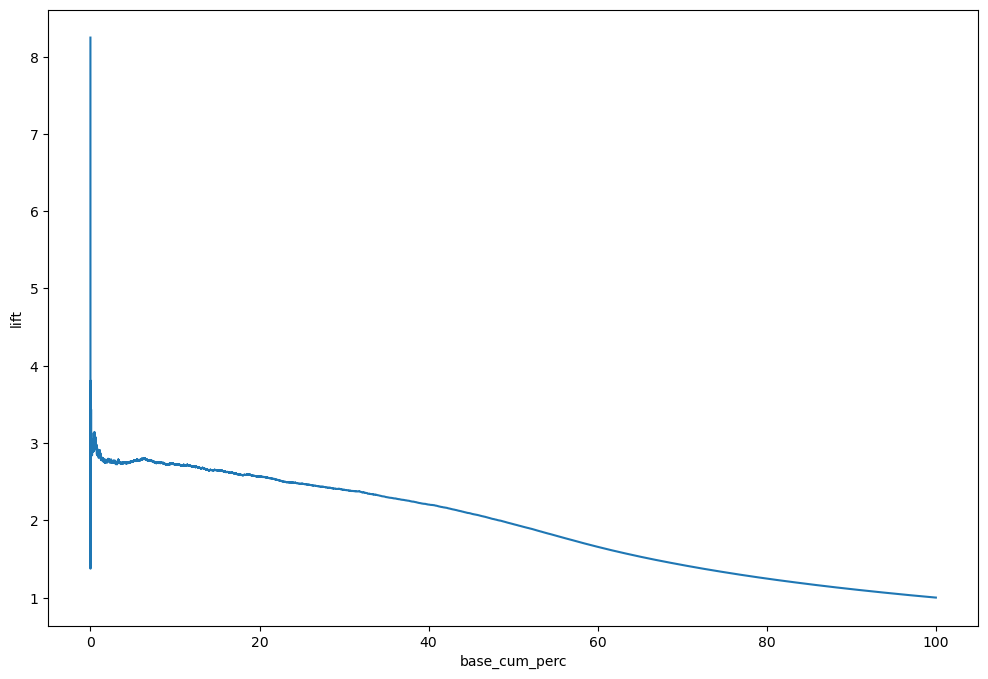

In [85]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values('prediction', ascending = False)

# Percentage of intereset (Propensity Score)
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100 * results['real_cum'] / results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range(1, len( results ) + 1)
results['base_cum_perc'] = 100 * results['base'] / len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

# ROI Curve
plt.figure(figsize=(12,8))
sns.lineplot(x = 'base_cum_perc', y = 'lift', data = results);

In [86]:
# Compute bucket
results['bucket'] = results['prediction'].apply(lambda x: 0.9 if x >= 0.90 else 
                                                    0.8 if ( x >= 0.80) & ( x <= 0.90 ) else 
                                                    0.7 if ( x >= 0.70) & ( x <= 0.80 ) else 
                                                    0.6 if ( x >= 0.60) & ( x <= 0.70 ) else 
                                                    0.5 if ( x >= 0.50) & ( x <= 0.60 ) else 
                                                    0.4 if ( x >= 0.40) & ( x <= 0.50 ) else 
                                                    0.3 if ( x >= 0.30) & ( x <= 0.40 ) else 
                                                    0.2 if ( x >= 0.20) & ( x <= 0.30 ) else 
                                                    0.1 if ( x >= 0.10) & ( x <= 0.20 ) else 
                                                    0.01)

#  Aggregate clients among buckets
df = results[['prediction','bucket']].groupby('bucket').agg({'min', 'count'}).reset_index()
df.columns = df.columns.droplevel()
df.columns = ['index', 'clients', 'propensity_score']

# Compute revenue and cost
df['gross_revenue'] = 40 * df['clients'] * df['propensity_score'] 
df['cost'] = 4 * df['clients']

df['base'] = df['clients'].sort_values(ascending=True).cumsum() / df['clients'].sum()

# revenue
df['revenue'] = df['gross_revenue'] - df['cost']
df = df.sort_values('index', ascending = False)
df

,index,clients,propensity_score,gross_revenue,cost,base,revenue
9,0.90,151,0.9,5436.0,604,0.001981,4832.0
8,0.80,275,0.8,8800.0,1100,0.005589,7700.0
7,0.70,554,0.7,15512.0,2216,0.012857,13296.0
6,0.60,1150,0.6,27600.0,4600,0.027945,23000.0
5,0.50,2070,0.5,41400.0,8280,0.055102,33120.0
4,0.40,3418,0.4,54688.0,13672,0.099945,41016.0
3,0.30,5194,0.3,62328.0,20776,0.168088,41552.0
2,0.20,6967,0.2,55736.0,27868,0.259492,27868.0
1,0.10,8382,0.1,33528.0,33528,0.369460,0.0
0,0.01,48061,0.0,0.0,192244,1.000000,-192244.0


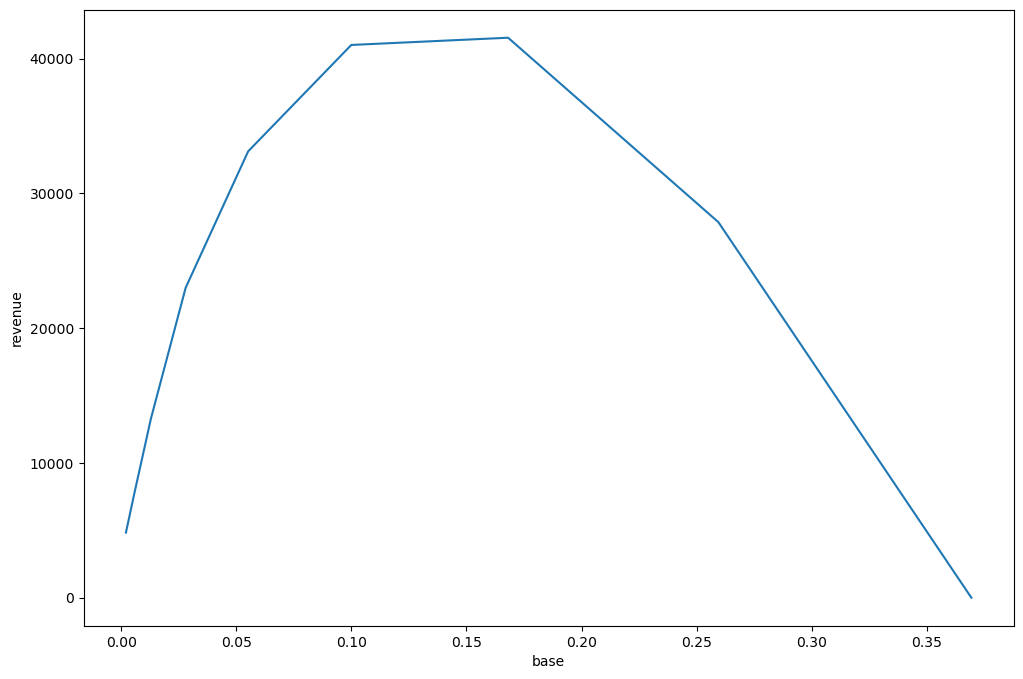

In [87]:
plt.figure( figsize=(12,8))
aux = df[df['propensity_score'] >= 0.1]
sns.lineplot( x='base', y='revenue', data=aux );

# 9.0. Deploy to Production